In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from glob import glob
import cv2

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
train = '/kaggle/input/module-1-chest-xray/chest_xray/train'

test = '/kaggle/input/module-1-chest-xray/chest_xray/test'


In [4]:
train_path = '/kaggle/input/module-1-chest-xray/chest_xray/train'
test_path = '/kaggle/input/module-1-chest-xray/chest_xray/test'
output_path = '/kaggle/working/train_clahe'  # 변환된 이미지를 저장할 경로
output_path1 = '/kaggle/working/test_clahe'
# 출력 폴더가 없으면 생성
os.makedirs(output_path, exist_ok=True)

# CLAHE 객체 생성
clahe = cv2.createCLAHE()

# 모든 이미지를 처리하는 함수
def apply_clahe_to_directory(directory, output_directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # 이미지 파일 경로
            image_path = os.path.join(root, file)
            
            # 이미지를 그레이스케일로 읽기
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"Warning: Could not read image {image_path}")
                continue
            
            # CLAHE 적용
            clahe_image = clahe.apply(image)
            
            # 변환된 이미지 저장 경로 설정
            relative_path = os.path.relpath(root, directory)
            output_dir = os.path.join(output_directory, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_image_path = os.path.join(output_dir, file)
            
            # 이미지 저장
            cv2.imwrite(output_image_path, clahe_image)

# 트레인 이미지 변환
apply_clahe_to_directory(train_path, output_path)
# apply_clahe_to_directory(test_path, output_path1)

In [87]:
train_transform = transforms.Compose([
        transforms.Resize(333),  # 모델의 크기가 다 달라서 일정한 사이즈로 조정
        transforms.RandomCrop(300), # 데이터 증강의 목적으로 300사이즈만큼 무작위로 이미지 커트
        transforms.RandomHorizontalFlip(), # 데이터증강의 목적으로 수평의 방향으로 이미지 뒤집기 / 과적합 방지
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(333),
        transforms.RandomCrop(300),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

In [88]:
train_data = datasets.ImageFolder(transform=train_transform,root=train)
test_data = datasets.ImageFolder(transform=test_transform,root=test)


train_loader = torch.utils.data.DataLoader(train_data,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=16)

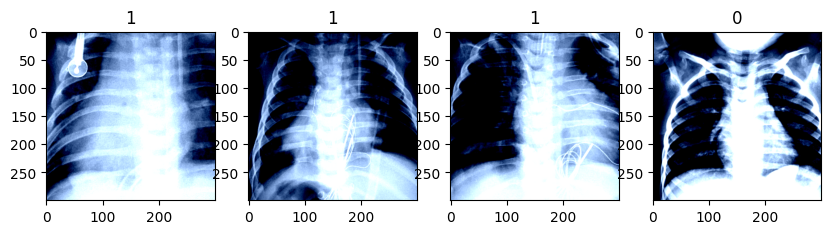

torch.Size([16, 3, 300, 300])


In [78]:
images,labels = next(iter(train_loader))

# Show images and labels
fig, axes = plt.subplots(figsize=(10, 10), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0))  
    ax.set_title(labels[i].item())
plt.show()
print(images.shape)

In [73]:
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint
class Model_3(nn.Module): # 81.56
    def __init__(self):
        super(Model_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) # 추가된 레이어
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) # 추가된 레이어
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(1024 * 4 * 4, 1024)  # 출력 크기 조정
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)  # 두 클래스를 위한 출력

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))  # 추가된 레이어
        x = self.pool(self.relu(self.conv6(x)))  # 추가된 레이어
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc3(x)  # 로짓 출력
        return x

# 모델 생성 및 출력 확인



In [ ]:
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) # 추가된 레이어
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) # 추가된 레이어
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(1024 * 4 * 4, 1024)  # 출력 크기 조정
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)  # 두 클래스를 위한 출력

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # 드롭아웃 추가

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))  # 추가된 레이어
        x = self.pool(self.relu(self.conv6(x)))  # 추가된 레이어
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.fc3(x)  # 로짓 출력
        return x

# 모델 생성 및 출력 확인



In [74]:
model3 = Model_3().to(device)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

for epoch in range(epochs):
    model3.train()
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} Training')):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model3(images)
        loss_value = criterion(preds, labels)  # 레이블은 1D
        loss_value.backward()
        optimizer.step()

    model3.eval()  # 모델을 평가 모드로 전환
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} Testing'):
            images, labels = images.to(device), labels.to(device)
            preds = model3(images)
            loss_value = criterion(preds, labels)  # 레이블은 1D
            test_loss += loss_value.item()

    print(f'Epoch {epoch+1}, Validation Loss: {test_loss/len(test_loader)}')

# 정확도 및 성능 평가
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

model3.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model3(images)
        
        # 로짓에 argmax를 적용하여 예측된 클래스를 결정
        predicted = torch.argmax(outputs, dim=1)
        
        true_labels.append(labels.cpu().numpy())
        predicted_labels.append(predicted.cpu().numpy())

true_labels = np.concatenate(true_labels)  
predicted_labels = np.concatenate(predicted_labels)  

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f}%')

report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print('Classification Report:')
print(report)


Epoch 1/20 Testing: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch 1, Validation Loss: 0.9800478704273701


Epoch 2/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch 2, Validation Loss: 0.901935932203196


Epoch 3/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Epoch 3, Validation Loss: 0.45496106129139663


Epoch 4/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 4, Validation Loss: 0.5935862607555464


Epoch 5/20 Testing: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch 5, Validation Loss: 0.528582452237606


Epoch 6/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Epoch 6, Validation Loss: 0.6254630408715457


Epoch 7/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Epoch 7, Validation Loss: 0.44697640193626287


Epoch 8/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Epoch 8, Validation Loss: 0.6129409847781062


Epoch 9/20 Testing: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch 9, Validation Loss: 0.4993385748937726


Epoch 10/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Epoch 10, Validation Loss: 0.5806314524263143


Epoch 11/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch 11, Validation Loss: 0.4038122039055452


Epoch 12/20 Testing: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch 12, Validation Loss: 0.7602346965169999


Epoch 13/20 Testing: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch 13, Validation Loss: 0.4044355404097587


Epoch 14/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch 14, Validation Loss: 0.7236762870394159


Epoch 15/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


Epoch 15, Validation Loss: 0.6423191089270404


Epoch 16/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Epoch 16, Validation Loss: 0.9638163046969567


Epoch 17/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch 17, Validation Loss: 0.6437997940462082


Epoch 18/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch 18, Validation Loss: 0.8900188278523273


Epoch 19/20 Testing: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 19, Validation Loss: 0.9031002356729004


Epoch 20/20 Testing: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch 20, Validation Loss: 0.7830913150741253


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]

Accuracy: 78.59%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.45      0.61       242
     Class 1       0.75      0.99      0.85       398

    accuracy                           0.79       640
   macro avg       0.86      0.72      0.73       640
weighted avg       0.83      0.79      0.76       640



In [79]:
if torch.cuda.is_available() == True:

    device ='cuda'
else :
    device = 'cpu'

device

'cuda'

In [80]:
model3 = Model_3().to(device)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

for epoch in range(epochs):
    model3.train()
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} Training')):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model3(images)
        loss_value = criterion(preds, labels)  # 레이블은 1D
        loss_value.backward()
        optimizer.step()

    model3.eval()  # 모델을 평가 모드로 전환
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} Testing'):
            images, labels = images.to(device), labels.to(device)
            preds = model3(images)
            loss_value = criterion(preds, labels)  # 레이블은 1D
            test_loss += loss_value.item()

    print(f'Epoch {epoch+1}, Validation Loss: {test_loss/len(test_loader)}')

# 정확도 및 성능 평가
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

model3.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model3(images)
        
        # 로짓에 argmax를 적용하여 예측된 클래스를 결정
        predicted = torch.argmax(outputs, dim=1)
        
        true_labels.append(labels.cpu().numpy())
        predicted_labels.append(predicted.cpu().numpy())

true_labels = np.concatenate(true_labels)  
predicted_labels = np.concatenate(predicted_labels)  

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f}%')

report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print('Classification Report:')
print(report)


Epoch 1/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Epoch 1, Validation Loss: 0.5391168763046152


Epoch 2/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Epoch 2, Validation Loss: 0.7633803848613752


Epoch 3/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  2.86it/s]


Epoch 3, Validation Loss: 0.5777756433584728


Epoch 4/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Epoch 4, Validation Loss: 0.803590262443322


Epoch 5/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 5, Validation Loss: 1.0043050255495474


Epoch 6/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


Epoch 6, Validation Loss: 0.6156297143141274


Epoch 7/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch 7, Validation Loss: 0.7736564209677453


Epoch 8/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


Epoch 8, Validation Loss: 0.41599321257090194


Epoch 9/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


Epoch 9, Validation Loss: 0.579657590406714


Epoch 10/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 10, Validation Loss: 0.6098721524853318


Epoch 11/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 11, Validation Loss: 0.5920476506464183


Epoch 12/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch 12, Validation Loss: 1.206105750392453


Epoch 13/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch 13, Validation Loss: 0.9974456718930014


Epoch 14/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 14, Validation Loss: 0.6676631146809087


Epoch 15/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Epoch 15, Validation Loss: 0.5495203889091499


Epoch 16/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 16, Validation Loss: 0.719299148072605


Epoch 17/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 17, Validation Loss: 0.7829711167774803


Epoch 18/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Epoch 18, Validation Loss: 0.6687465497117955


Epoch 19/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


Epoch 19, Validation Loss: 0.8277468467033031


Epoch 20/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch 20, Validation Loss: 0.6406008801230201


100%|██████████| 40/40 [00:12<00:00,  3.16it/s]

Accuracy: 81.56%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.53      0.68       242
     Class 1       0.78      0.99      0.87       398

    accuracy                           0.82       640
   macro avg       0.87      0.76      0.78       640
weighted avg       0.85      0.82      0.80       640



In [81]:
model3 = Model_3().to(device)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 20
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0005)

for epoch in range(epochs):
    model3.train()
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} Training')):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model3(images)
        loss_value = criterion(preds, labels)  # 레이블은 1D
        loss_value.backward()
        optimizer.step()

    model3.eval()  # 모델을 평가 모드로 전환
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} Testing'):
            images, labels = images.to(device), labels.to(device)
            preds = model3(images)
            loss_value = criterion(preds, labels)  # 레이블은 1D
            test_loss += loss_value.item()

    print(f'Epoch {epoch+1}, Validation Loss: {test_loss/len(test_loader)}')

# 정확도 및 성능 평가
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

model3.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model3(images)
        
        # 로짓에 argmax를 적용하여 예측된 클래스를 결정
        predicted = torch.argmax(outputs, dim=1)
        
        true_labels.append(labels.cpu().numpy())
        predicted_labels.append(predicted.cpu().numpy())

true_labels = np.concatenate(true_labels)  
predicted_labels = np.concatenate(predicted_labels)  

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f}%')

report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print('Classification Report:')
print(report)


Epoch 1/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch 1, Validation Loss: 0.9455615139304427


Epoch 2/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


Epoch 2, Validation Loss: 0.7788135638402309


Epoch 3/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 3, Validation Loss: 0.7997487501779688


Epoch 4/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 4, Validation Loss: 0.5208025004249066


Epoch 5/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch 5, Validation Loss: 0.9076220029721298


Epoch 6/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


Epoch 6, Validation Loss: 0.8753616801812314


Epoch 7/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Epoch 7, Validation Loss: 0.8236384956631809


Epoch 8/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


Epoch 8, Validation Loss: 0.9589998789515448


Epoch 9/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


Epoch 9, Validation Loss: 0.5761540109524503


Epoch 10/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Epoch 10, Validation Loss: 0.5789654596417677


Epoch 11/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Epoch 11, Validation Loss: 1.1066482867696776


Epoch 12/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Epoch 12, Validation Loss: 0.7743356398044853


Epoch 13/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 13, Validation Loss: 0.6066930488741491


Epoch 14/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch 14, Validation Loss: 0.7618485555925872


Epoch 15/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


Epoch 15, Validation Loss: 1.341372962412845


Epoch 16/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch 16, Validation Loss: 0.5519561728840927


Epoch 17/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


Epoch 17, Validation Loss: 0.558790480823518


Epoch 18/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch 18, Validation Loss: 0.40093604566063734


Epoch 19/20 Testing: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch 19, Validation Loss: 0.5907773254424683


Epoch 20/20 Testing: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


Epoch 20, Validation Loss: 0.896815201946356


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]

Accuracy: 80.47%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.50      0.66       242
     Class 1       0.77      0.99      0.86       398

    accuracy                           0.80       640
   macro avg       0.87      0.74      0.76       640
weighted avg       0.84      0.80      0.79       640

